In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from datetime import datetime
import warnings

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning, module="prophet.plot")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


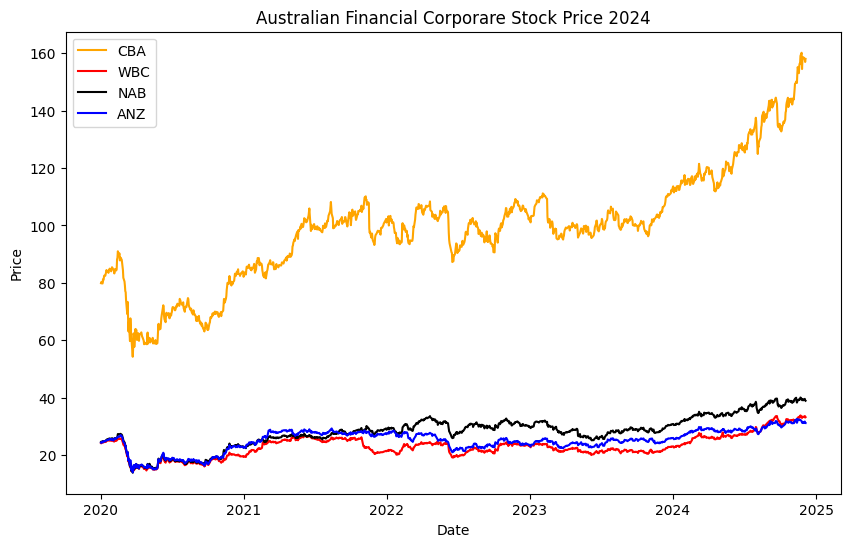

In [3]:
# Download stock data for corporates
stock_data_comm = yf.download('CBA.AX', start='2020-01-01')
stock_data_westpac = yf.download('WBC.AX', start='2020-01-01')
stock_data_nab = yf.download('NAB.AX', start='2020-01-01')
stock_data_anz = yf.download('ANZ.AX', start='2020-01-01')

# Plot the stock prices
plt.figure(figsize=(10,6))
plt.plot(stock_data_comm['Close'], label = 'CBA', color = 'orange')
plt.plot(stock_data_westpac['Close'], label = 'WBC', color = 'red')
plt.plot(stock_data_nab['Close'], label = 'NAB', color = 'black')
plt.plot(stock_data_anz['Close'], label = 'ANZ', color = 'blue')
plt.title('Australian Financial Corporare Stock Price 2024')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [6]:
def stock_price_prediction(df, data_column, periods):
    prophet_df = df["Close"]
    prophet_df = prophet_df.reset_index().rename(columns = {"Date": "ds", data_column: "y"})
    prophet_df["ds"] = pd.to_datetime(prophet_df["ds"]).dt.tz_localize(None)
    prophet_df = prophet_df.sort_values("ds")
    
    model = Prophet()
    model.fit(prophet_df)
    future = model.make_future_dataframe(periods = periods)
    forecast = model.predict(future)
    
    return forecast, model

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


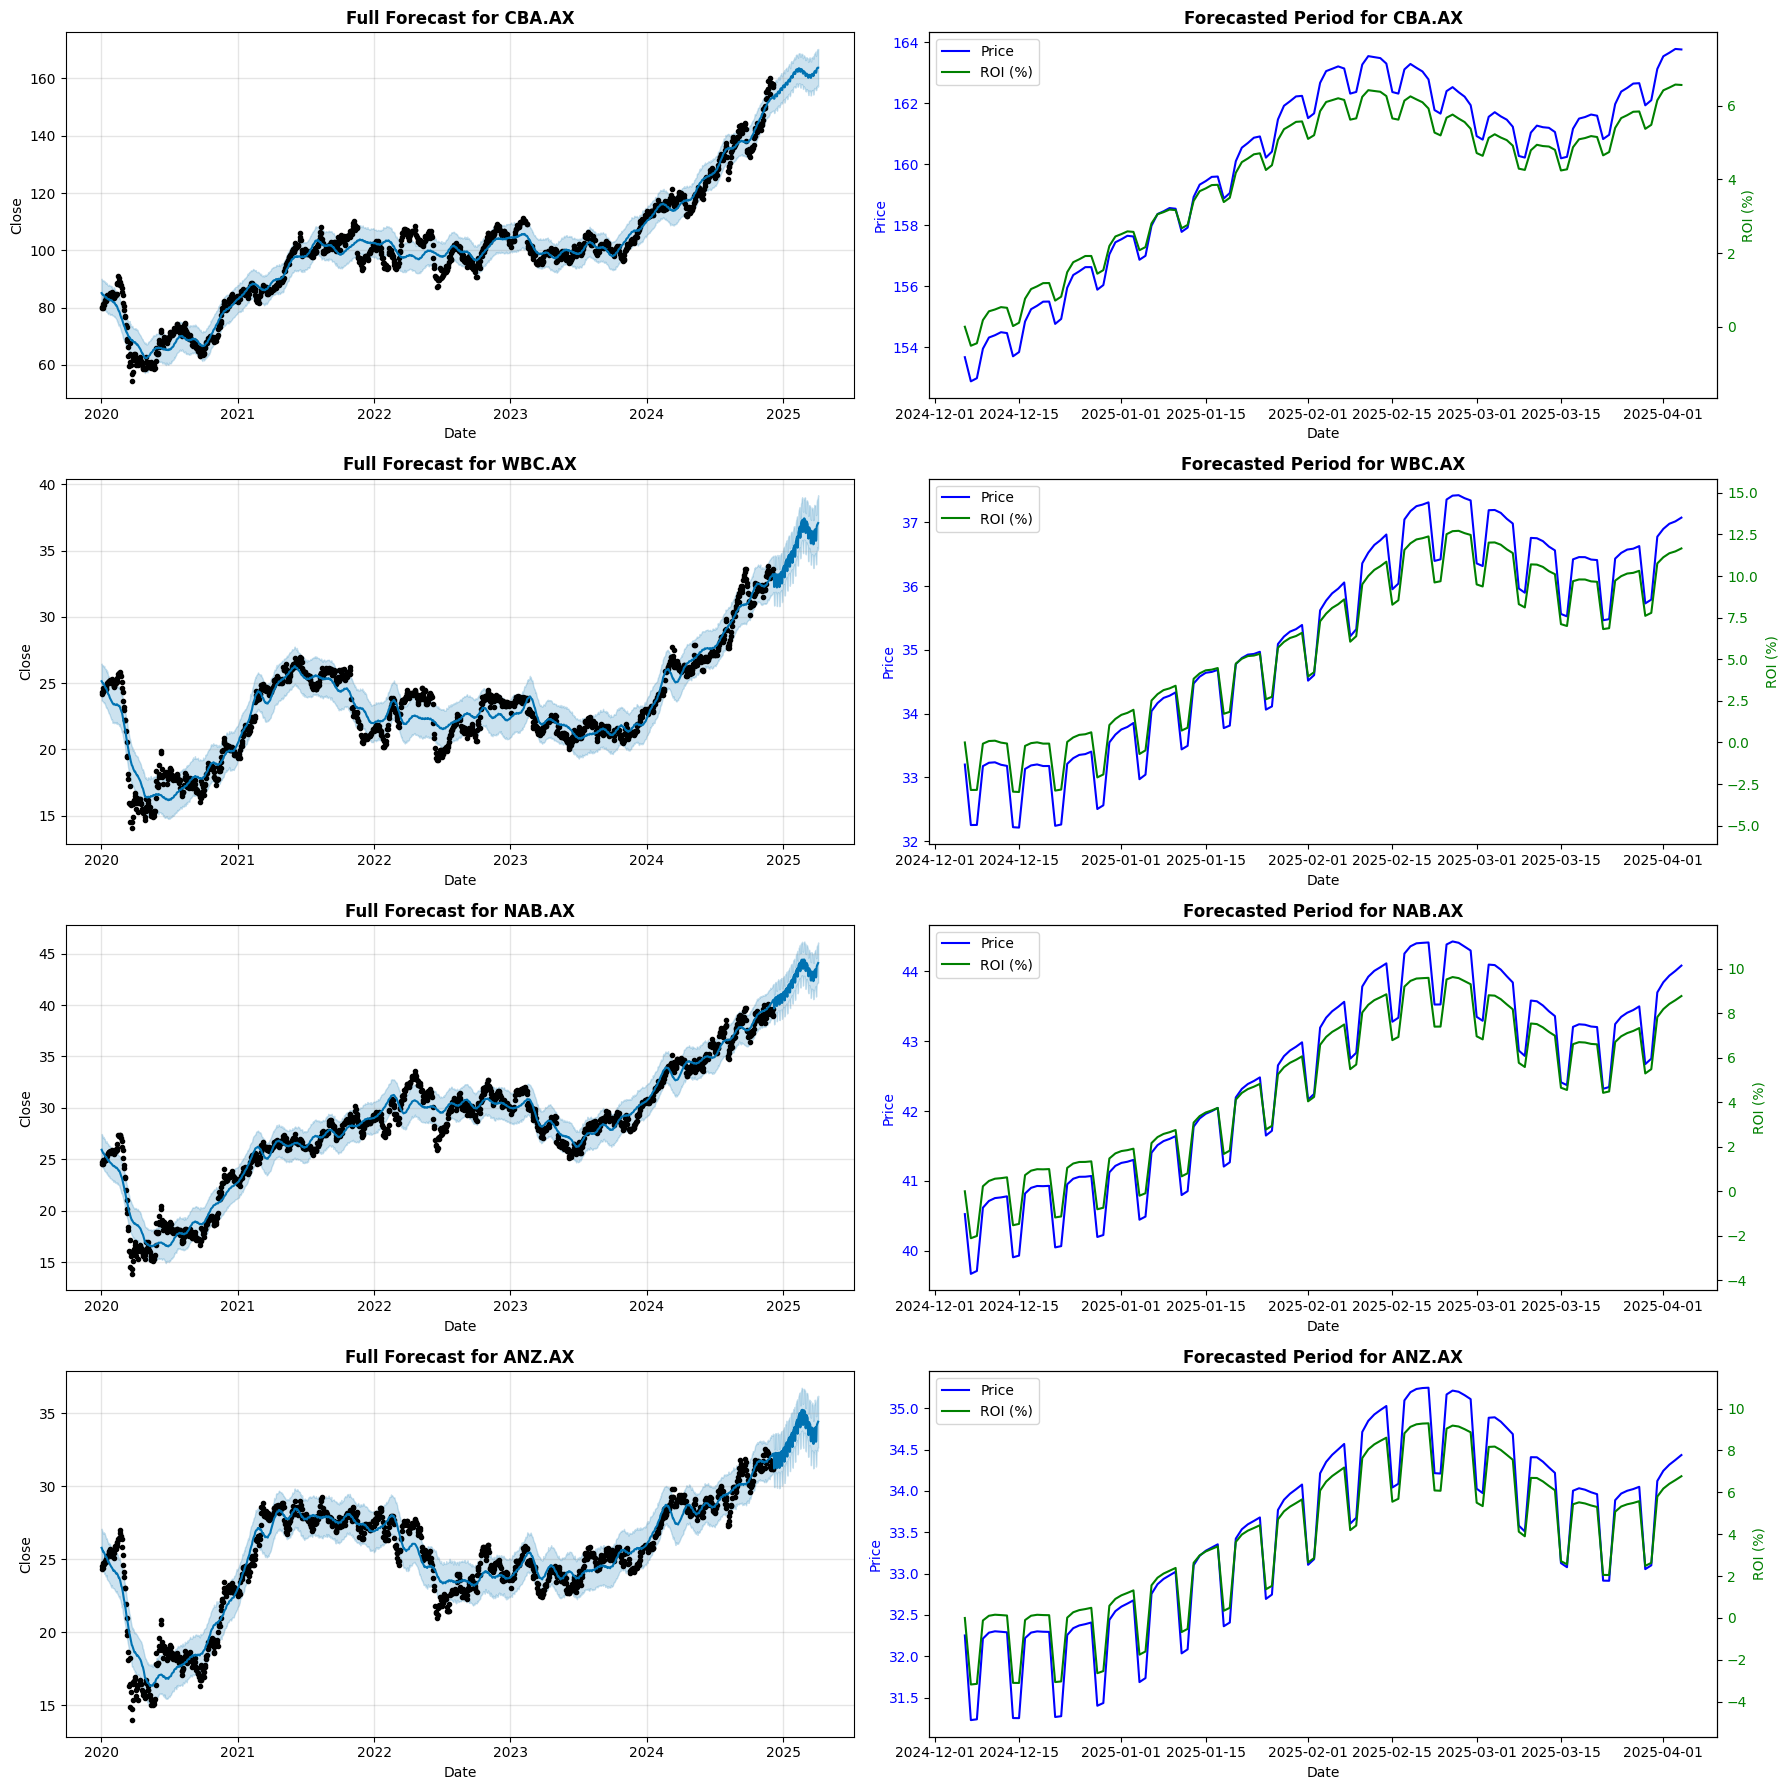

In [8]:
stock_data = [[stock_data_comm, "CBA.AX"], [stock_data_westpac, "WBC.AX"], [stock_data_nab, "NAB.AX"], [stock_data_anz, "ANZ.AX"]]

fig, axes = plt.subplots(4, 2, figsize=(18, 18))
axes = axes.flatten()

def calculate_roi_for_predictions(predictions, initial_price):
    return [(day - initial_price) / initial_price * 100 for day in predictions]

for i in range(len(stock_data)):
    stock = stock_data[i]
    forecast, model = stock_price_prediction(stock[0], stock[1], 120)
    
    # Left column: Full forecast plot
    model.plot(forecast, xlabel="Date", ylabel="Close", ax=axes[2 * i])
    axes[2 * i].set_title(f"Full Forecast for {stock[1]}", fontsize=12, fontweight="bold")
    
    # Extract forecasted period data
    results = forecast[forecast["ds"] >= datetime.now()][["ds", "yhat"]].reset_index(drop=True)
    predictions = results["yhat"].values
    initial_price = predictions[0]
    
    # Calculate ROI for the forecasted period
    roi = calculate_roi_for_predictions(predictions, initial_price)
    
    # Right column: Dual y-axes plot
    ax_price = axes[2 * i + 1]
    ax_price.set_title(f"Forecasted Period for {stock[1]}", fontsize=12, fontweight="bold")
    ax_price.set_xlabel('Date')
    
    # Plot price predictions on the primary y-axis
    price_line, = ax_price.plot(results["ds"], predictions, label="Price", color="blue")
    ax_price.set_ylabel('Price', color='blue')
    ax_price.tick_params(axis='y', labelcolor='blue')
    
    # Create secondary y-axis for ROI
    ax_roi = ax_price.twinx()
    roi_line, = ax_roi.plot(results["ds"], roi, label="ROI (%)", color="green")
    ax_roi.set_ylabel('ROI (%)', color='green')
    ax_roi.tick_params(axis='y', labelcolor='green')
    
    # Dynamically adjust ROI y-axis range
    roi_min = min(roi)
    roi_max = max(roi)
    margin = 0.2 * (roi_max - roi_min)  # Add 20% margin for better visualization
    ax_roi.set_ylim(roi_min - margin, roi_max + margin)
    
    # Combine legends for the two y-axes
    lines = [price_line, roi_line]
    labels = ["Price", "ROI (%)"]
    ax_price.legend(lines, labels, loc="upper left", frameon=True)

plt.tight_layout()
plt.show()